In [ ]:
# !gcloud auth application-default login --scopes=openid,https://www.googleapis.com/auth/cloud-platform,https://www.googleapis.com/auth/drive.readonly

In [1]:
from google.cloud import bigquery

In [2]:
bq = bigquery.Client()

In [3]:
%load_ext google.cloud.bigquery

In [4]:
project_name = "calcium-aria-397903"
f"{project_name}"

'calcium-aria-397903'

# ML on practice data

In [5]:
# practice data 1
import pandas as pd
import numpy as np
df = pd.DataFrame({"x1": np.random.randint(0, 10, 100).astype(float), 
                   "x2": np.random.randint(0, 3, 100).astype(float)})
df["y"] = df["x1"] + df["x2"] + np.random.rand(len(df))

In [6]:
df.head(3)

,x1,x2,y
0,7.0,1.0,8.270216
1,4.0,1.0,5.249604
2,2.0,2.0,4.277170


In [9]:
# df.to_parquet("test.parquet")

In [10]:
# !ls

In [7]:
ds = bigquery.Dataset(f"{project_name}.test1")
bq.create_dataset(ds, exists_ok=True)

Dataset(DatasetReference('calcium-aria-397903', 'test1'))

In [8]:
for ds in bq.list_datasets(f"{project_name}"):
    print(ds.dataset_id)

p8
test1
test2
test3


In [11]:
# gbq: Google BigQuery; save data in bigquery table "sampl"
df.to_gbq(f"{project_name}.test1.samp1", if_exists="replace")

100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7219.11it/s]


In [12]:
# list of tables in test1 dataset
for tbl in bq.list_tables(f"{project_name}.test1"):
    print(tbl.table_id)

samp1
traintest


### spliting train and test

In [ ]:
#  create a table "traintest"

In [30]:
%%bigquery
CREATE OR REPLACE TABLE test1.traintest

AS

SELECT *, rand()<0.25 AS test
FROM test1.samp1

Query is running:   0%|          |

""


In [33]:
%%bigquery df
SELECT COUNT(*) AS count
FROM test1.samp1

Query is running:   0%|          |

Downloading:   0%|          |

In [34]:
df

,f0_
0,100


In [35]:
%%bigquery df
SELECT COUNT(*)
FROM test1.traintest

Query is running:   0%|          |

Downloading:   0%|          |

In [36]:
df

,f0_
0,100


In [37]:
%%bigquery df
SELECT *
FROM test1.traintest
LIMIT 5

Query is running:   0%|          |

Downloading:   0%|          |

In [38]:
df

,x1,x2,y,test
0,0.0,0.0,0.675606,False
1,0.0,0.0,0.305345,False
2,0.0,0.0,0.752916,True
3,2.0,0.0,2.189982,False
4,2.0,0.0,2.779058,False


In [19]:
# list of tables in test1 dataset
for tbl in bq.list_tables(f"{project_name}.test1"):
    print(tbl.table_id)

samp1
traintest


### train model "lr"

In [20]:
%%bigquery
CREATE OR REPLACE MODEL `test1.lr`
OPTIONS(model_type="LINEAR_REG", INPUT_LABEL_COLS=["y"])

AS

SELECT x1, x2, y
FROM test1.traintest
WHERE NOT test

Query is running:   0%|          |

""


### look at model weights

In [21]:
%%bigquery
SELECT *
FROM ML.WEIGHTS(MODEL `test1.lr`)

Query is running:   0%|          |

Downloading:   0%|          |

,processed_input,weight,category_weights
0,x1,0.984738,[]
1,x2,0.930290,[]
2,__INTERCEPT__,0.615400,[]


### predictions from model "lr"

In [22]:
%%bigquery
SELECT *
FROM ML.PREDICT(MODEL `test1.lr`, (
    SELECT x1, x2, y
    FROM test1.traintest
    WHERE test
))

Query is running:   0%|          |

Downloading:   0%|          |

,predicted_y,x1,x2,y
0,0.615400,0.0,0.0,0.752916
1,2.584876,2.0,0.0,2.189982
2,3.569614,3.0,0.0,3.527496
3,3.569614,3.0,0.0,3.232998
4,4.554353,4.0,0.0,4.878329
5,1.600138,1.0,0.0,1.330202
6,4.445456,2.0,2.0,4.959028
7,4.445456,2.0,2.0,4.258260
8,4.445456,2.0,2.0,4.296100
9,5.430194,3.0,2.0,5.627600


### evaluate model quality

In [23]:
%%bigquery df
SELECT *
FROM ML.EVALUATE(MODEL `test1.lr`, (
    SELECT x1, x2, y
    FROM test1.traintest
    WHERE test
))

Query is running:   0%|          |

Downloading:   0%|          |

In [24]:
df

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,0.28088,0.097569,0.004397,0.309867,0.98946,0.990664


In [25]:
df.at[0,"r2_score"]

0.989460432809082

# Transformers

In [13]:
df = pd.DataFrame({"x1": np.random.randint(0, 10, 100).astype(float), 
                   "x2": np.random.randint(0, 3, 100).astype(float)})
df["y"] = 2 * df["x1"] ** 2 - 3 * df["x2"] + np.random.rand(len(df))
df.head()

,x1,x2,y
0,6.0,1.0,69.533191
1,9.0,0.0,162.834302
2,5.0,2.0,44.774868
3,8.0,2.0,122.127229
4,7.0,0.0,98.631560


In [14]:
# df.to_parquet("tbl1.parquet")

In [16]:
df.to_gbq("test1.tbl1")

100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]


#### train without transforming and look at accuracy

In [17]:
%%bigquery
CREATE OR REPLACE MODEL `test1.m1`
OPTIONS(model_type="LINEAR_REG", INPUT_LABEL_COLS=["y"])

AS

SELECT x1, x2, y
FROM test1.tbl1

Query is running:   0%|          |

""


In [19]:
%%bigquery df
SELECT *
FROM ML.EVALUATE(MODEL `test1.m1`, (
    SELECT x1,x2,y
    FROM test1.tbl1
))

Query is running:   0%|          |

Downloading:   0%|          |

In [20]:
df

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,11.557191,179.292988,0.064354,11.263231,0.937906,0.937906


#### transform non-linear data

In [21]:
%%bigquery
SELECT x1, POWER(x1,2) as x1_2, x2, POWER(x2,2) as x2_2,y
FROM test1.tbl1
LIMIT 5

Query is running:   0%|          |

Downloading:   0%|          |

,x1,x1_2,x2,x2_2,y
0,0.0,0.0,0.0,0.0,0.536347
1,2.0,4.0,0.0,0.0,8.216725
2,2.0,4.0,0.0,0.0,8.397470
3,2.0,4.0,0.0,0.0,8.992636
4,2.0,4.0,0.0,0.0,8.993930


In [22]:
%%bigquery
CREATE OR REPLACE MODEL `test1.m2`
TRANSFORM(x1, POWER(x1,2) as x1_2, x2, POWER(x2,2) as x2_2, y)
OPTIONS(model_type="LINEAR_REG", INPUT_LABEL_COLS=["y"])

AS

SELECT x1,x2,y
FROM test1.tbl1

Query is running:   0%|          |

""


In [24]:
%%bigquery
SELECT *
FROM
ML.EVALUATE(MODEL `test1.m2`, (
    SELECT x1,x2,y
    FROM test1.tbl1
))

Query is running:   0%|          |

Downloading:   0%|          |

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,0.225862,0.069741,0.020454,0.225188,0.999976,0.999976


### compare m1 to m2

In [26]:
%%bigquery
SELECT *
FROM ML.EVALUATE(MODEL `test1.m1`, (
    SELECT x1,x2,y
    FROM test1.tbl1
))

UNION ALL

SELECT *
FROM ML.EVALUATE(MODEL `test1.m2`, (
    SELECT x1,x2,y
    FROM test1.tbl1
))

Query is running:   0%|          |

Downloading:   0%|          |

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,0.225862,0.069741,0.020454,0.225188,0.999976,0.999976
1,11.557191,179.292988,0.064354,11.263231,0.937906,0.937906


In [27]:
%%bigquery df
SELECT "m1" as model, r2_score
FROM ML.EVALUATE(MODEL `test1.m1`, (
    SELECT x1,x2,y
    FROM test1.tbl1
))

UNION ALL

SELECT "m2" as model, r2_score
FROM ML.EVALUATE(MODEL `test1.m2`, (
    SELECT x1,x2,y
    FROM test1.tbl1
))

Query is running:   0%|          |

Downloading:   0%|          |

In [28]:
df

,model,r2_score
0,m2,0.999976
1,m1,0.937906


Text(0, 0.5, 'R^2 Score')

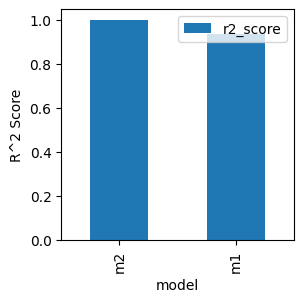

In [31]:
ax = df.set_index("model").plot.bar(figsize=(3,3))
ax.set_ylabel("R^2 Score")

### transform categorical data

In [32]:
# practice data 2
df = pd.DataFrame({"x1": np.random.choice(["A", "B", "C"], 100), 
                   "x2": np.random.randint(0, 10, 100).astype(float)})
df["y"] = df["x1"].map({"A":1, "B":5, "C":15}) + 2 * df["x2"] + np.random.rand(len(df))
df.head(3)

,x1,x2,y
0,B,3.0,11.284828
1,B,0.0,5.147133
2,B,8.0,21.448745


In [34]:
# df.to_parquet("tbl2.parquet")
df.to_gbq("test1.tbl2")

100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8224.13it/s]


In [36]:
# train model

In [35]:
%%bigquery
CREATE OR REPLACE MODEL test1.m3
OPTIONS(model_type="LINEAR_REG", INPUT_LABEL_COLS=["y"])
AS
SELECT * FROM test1.tbl2

Query is running:   0%|          |

""


In [37]:
# evaluate

In [39]:
%%bigquery
SELECT *
FROM ML.EVALUATE(MODEL `test1.m3`, (
    SELECT x1,x2,y
    FROM test1.tbl2
))

Query is running:   0%|          |

Downloading:   0%|          |

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,0.220358,0.069823,0.000724,0.216528,0.999033,0.999033


In [40]:
%%bigquery df
SELECT *
FROM
ML.WEIGHTS(MODEL test1.m3)

Query is running:   0%|          |

Downloading:   0%|          |

In [41]:
df

,processed_input,weight,category_weights
0,x1,NaN,"[{'category': 'A', 'weight': -18.0}, {'categor..."
1,x2,1.997911,[]
2,__INTERCEPT__,19.540392,[]


In [42]:
weights = pd.DataFrame(df.set_index("processed_input").at["x1", "category_weights"].tolist())
weights

,category,weight
0,A,-18.000000
1,C,-4.109375
2,B,-14.077554


<Axes: xlabel='category'>

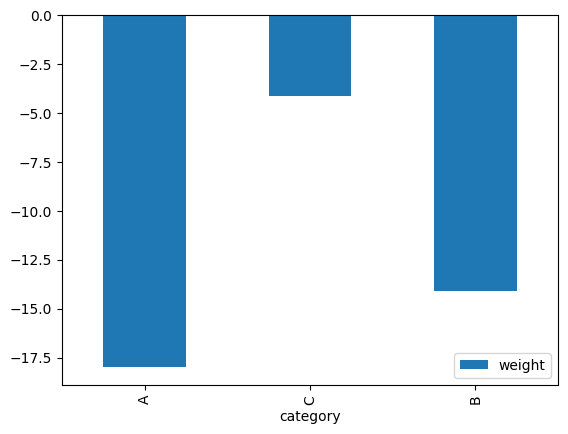

In [43]:
weights.set_index("category").plot.bar()